In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


In [2]:

# Parameters that were used when saving
sigma_vals = np.linspace(0.0, 1.0, 51)
nshell_list = [1, 2, 3, None]
N_list = [16, 32, 64]
samples = 100
mu = 0


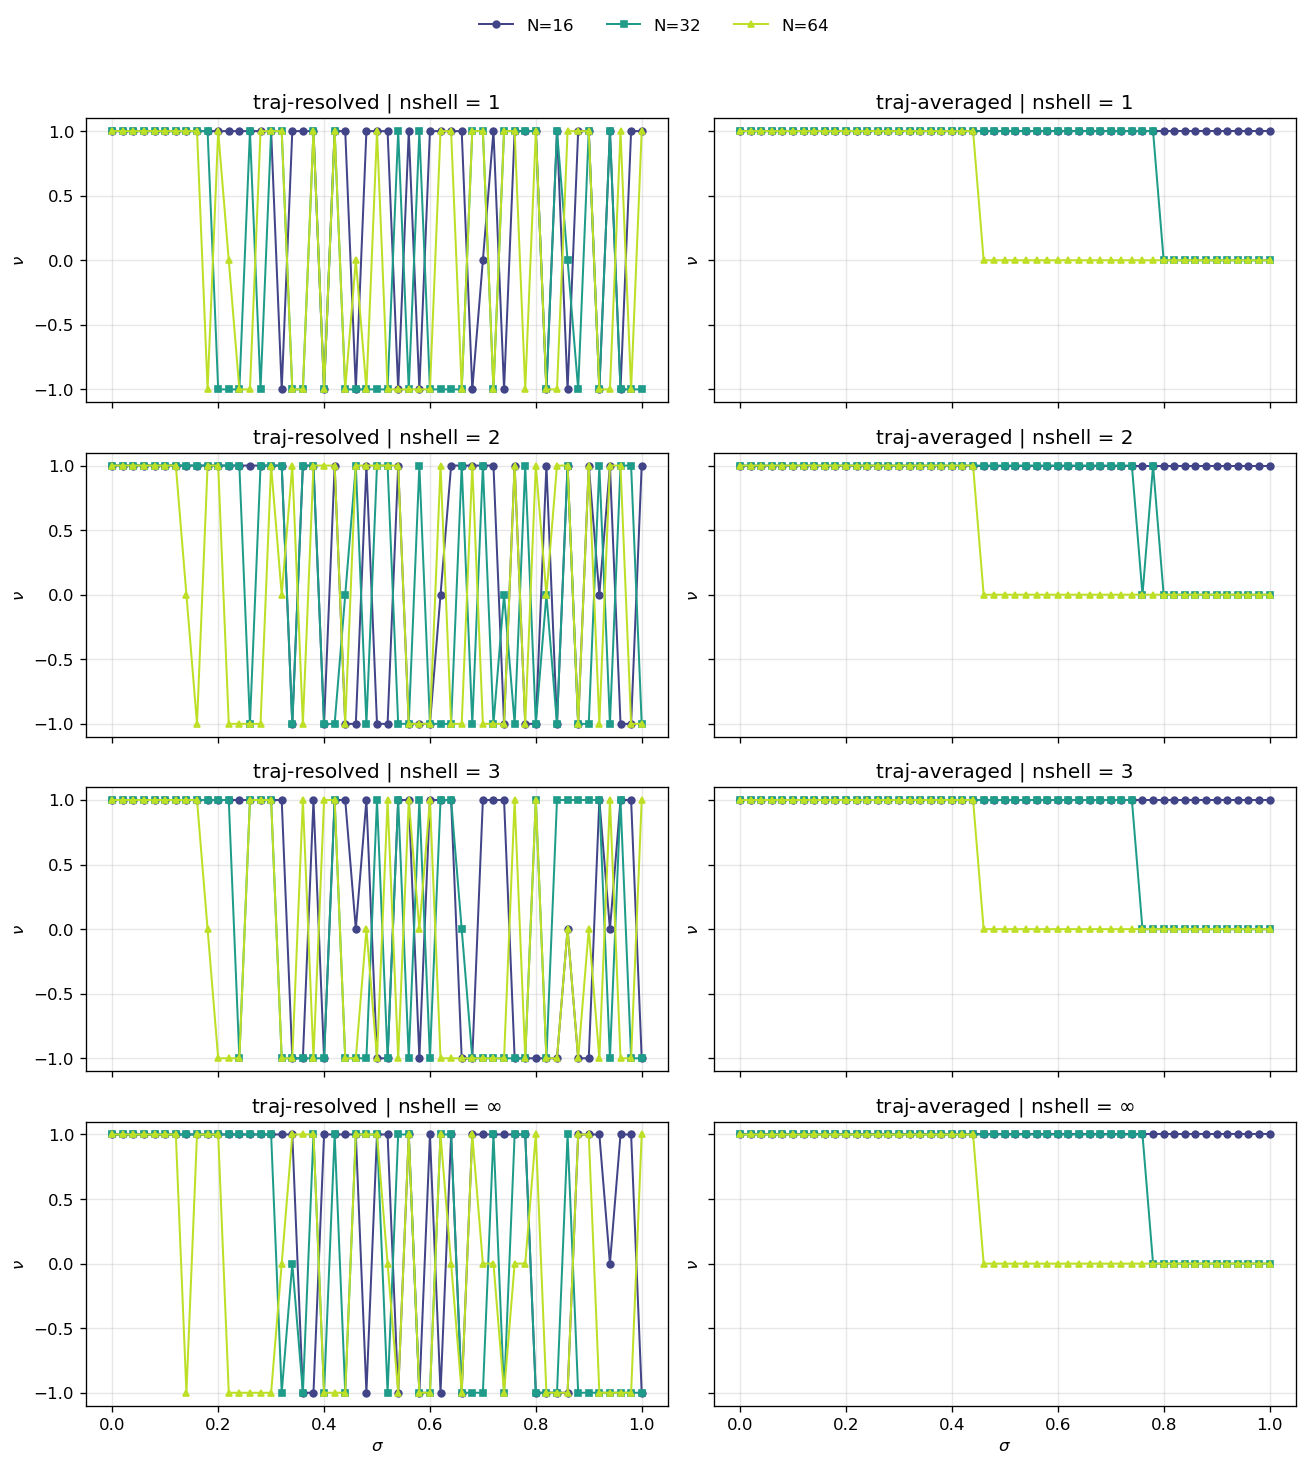

In [ ]:

# Where the .npz files live
results_dir = "results"

plt.rcParams.update({"figure.dpi": 120})

fig, axes = plt.subplots(
    nrows=len(nshell_list),
    ncols=2,
    figsize=(11, 12),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(hspace=0.15, wspace=0.1)
if len(nshell_list) == 1:
    axes = np.array([axes])

colors = cm.viridis(np.linspace(0.2, 0.9, len(N_list)))
markers = ["o", "s", "^", "D", "P"]

for row_idx, nshell in enumerate(nshell_list):
    ax_res = axes[row_idx, 0]
    ax_avg = axes[row_idx, 1]
    nshell_label = r"$\infty$" if nshell is None else nshell
    nshell_tag = "inf" if nshell is None else str(nshell)

    for ci, N in enumerate(N_list):
        fname = f"kitaev_inv_sigma_N{N}_nsh{nshell_tag}_samples{samples}_mu={mu}.npz"
        path = os.path.join(results_dir, fname)
        data = np.load(path)

        resolved_mean = data["traj_resolved_mean"]
        traj_avg = data["traj_avg"]

        label = f"N={N}"
        ax_res.plot(
            sigma_vals,
            resolved_mean,
            marker=markers[ci % len(markers)],
            color=colors[ci],
            label=label,
            linewidth=1.2,
            markersize=4,
        )
        ax_avg.plot(
            sigma_vals,
            traj_avg,
            marker=markers[ci % len(markers)],
            color=colors[ci],
            label=label,
            linewidth=1.2,
            markersize=4,
        )

    ax_res.set_ylabel(r"$\nu$")
    ax_avg.set_ylabel(r"$\nu$")
    ax_res.grid(alpha=0.3)
    ax_avg.grid(alpha=0.3)
    ax_res.set_title(f"traj-resolved | nshell = {nshell_label}")
    ax_avg.set_title(f"traj-averaged | nshell = {nshell_label}")

axes[-1, 0].set_xlabel(r"$\sigma$")
axes[-1, 1].set_xlabel(r"$\sigma$")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(N_list), bbox_to_anchor=(0.5, 1.02), frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.97])
#fig.savefig(os.path.join(results_dir, f"kitaev_invariant_vs_sigma_mu{mu}_samples{samples}.png"), dpi=300, bbox_inches="tight")
plt.show()


In [36]:
import os, sys, time, numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

import importlib
import classD_1dMFGTN  # ensure correct module name
importlib.reload(classD_1dMFGTN)
from classD_1dMFGTN import classD_1d_MFGTN

_CPU_LIMIT = 10


In [37]:
def average_over_samples(N, nshell, sigma_vals, mu_1, samples=100, n_jobs=None, cycles=20):
    """
    Compute trajectory-resolved and trajectory-averaged Kitaev invariants vs sigma.
    traj-resolved: compute invariant per trajectory then average.
    traj-averaged: average G across trajectories first, then compute invariant.
    """
    resolved_mean = []
    resolved_std = []
    traj_avg_vals = []

    for sigma in tqdm(sigma_vals, desc=f"N={N}, nshell={nshell}"):
        model = classD_1d_MFGTN(N=N, DW=False, nshell=nshell, mu_1=mu_1, mu_2=mu_1, t_1=1.0)
        model.construct_MW_projectors(nshell=nshell)
        res = model.run_adaptive_circuit(
            G_history=True,
            progress=False,
            cycles=cycles,
            postselect=False,
            samples=samples,
            n_jobs=n_jobs,
            backend="loky",
            parallelize_samples=True,
            store="top",
            init_mode="random_pure",
            remember_init=False,
            save=False,
            sigma=sigma,
        )
        top_hist = res["G_hist"]  # shape (samples, cycles, 2N, 2N)
        finals = np.asarray(top_hist[:, -1])

        traj_resolved = [model.kitaev_invariant(Gk) for Gk in finals]
        G_avg = np.mean(finals, axis=0)
        G_avg = 0.5 * (G_avg - G_avg.T)  # enforce skew-symmetry before Pfaffian
        traj_avg = model.kitaev_invariant(G_avg)

        resolved_mean.append(np.mean(traj_resolved))
        resolved_std.append(np.std(traj_resolved))
        traj_avg_vals.append(traj_avg)

    return np.array(resolved_mean), np.array(resolved_std), np.array(traj_avg_vals)


Crossed multisample threshold at cycle 10; spawning parallel samples.


samples:   0%|          | 0/10 [00:00<?, ?task/s]

N=16, nshell=None: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]

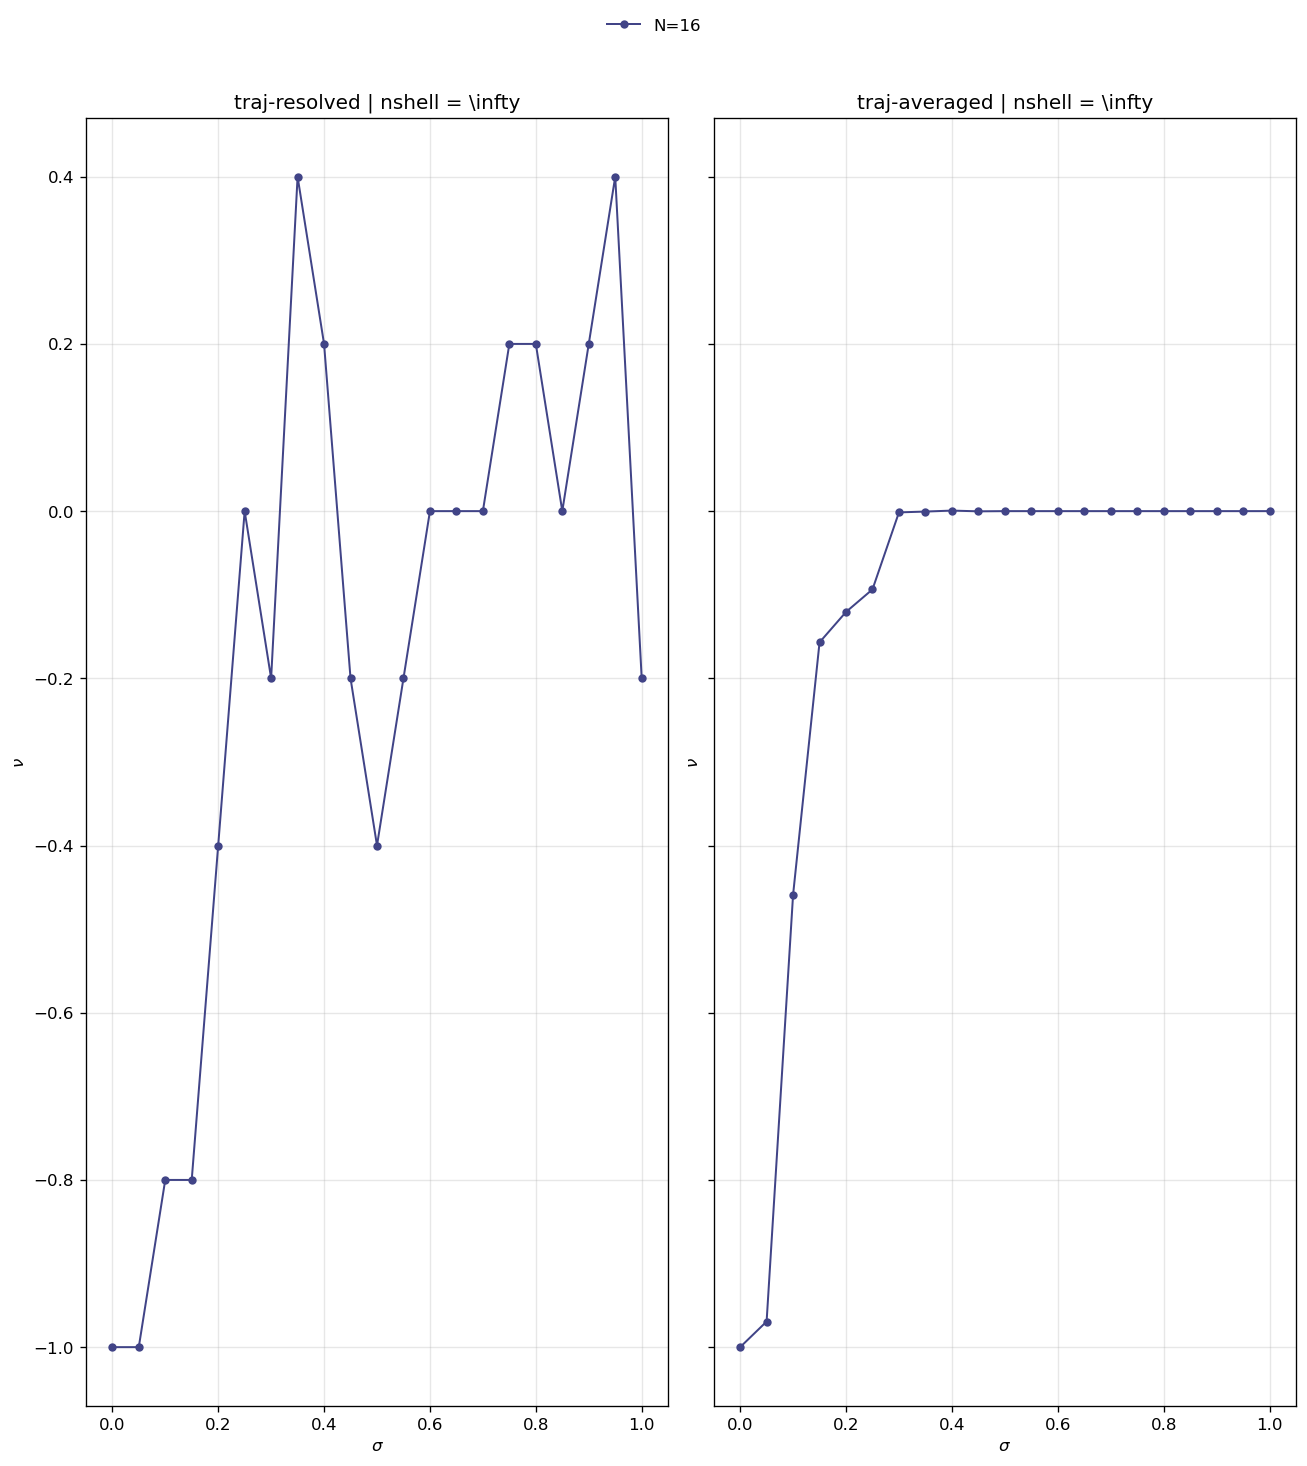

In [38]:

# Params
sigma_vals = np.linspace(0.0, 1.0, 21)
nshell_list = [None]
N_list = [16]
samples = 10
cycles = 20
mu = 0
n_jobs = _CPU_LIMIT

plt.rcParams.update({"figure.dpi": 120})

fig, axes = plt.subplots(
    nrows=len(nshell_list),
    ncols=2,
    figsize=(11, 12),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(hspace=0.15, wspace=0.1)
if len(nshell_list) == 1:
    axes = np.array([axes])

colors = cm.viridis(np.linspace(0.2, 0.9, len(N_list)))
markers = ["o", "s", "^", "D", "P"]

traj_resolved_mean = {}
traj_resolved_std = {}
traj_avg_vals = {}

for row_idx, nshell in enumerate(nshell_list):
    ax_res = axes[row_idx, 0]
    ax_avg = axes[row_idx, 1]
    nshell_label = r"\infty" if nshell is None else nshell
    nshell_tag = "inf" if nshell is None else str(nshell)

    for ci, N in enumerate(N_list):
        key = (N, nshell)
        resolved_mean, resolved_std, traj_avg = average_over_samples(
            N, nshell, sigma_vals, mu_1=mu, samples=samples, n_jobs=n_jobs, cycles=cycles
        )
        traj_resolved_mean[key] = resolved_mean
        traj_resolved_std[key] = resolved_std
        traj_avg_vals[key] = traj_avg

        label = f"N={N}"
        ax_res.plot(
            sigma_vals,
            resolved_mean,
            marker=markers[ci % len(markers)],
            color=colors[ci],
            label=label,
            linewidth=1.2,
            markersize=4,
        )
        ax_avg.plot(
            sigma_vals,
            traj_avg,
            marker=markers[ci % len(markers)],
            color=colors[ci],
            label=label,
            linewidth=1.2,
            markersize=4,
        )

        #outdir = "results"
        #os.makedirs(outdir, exist_ok=True)
        #fname = f"kitaev_inv_sigma_N{N}_nsh{nshell_tag}_samples{samples}_mu={mu}.npz"
        #path = os.path.join(outdir, fname)
        #np.savez_compressed(
        #    path,
        #    sigma=sigma_vals,
        #    traj_resolved_mean=resolved_mean,
        #    traj_resolved_std=resolved_std,
        #    traj_avg=traj_avg,
        #    N=N,
        #    nshell=nshell,
        #    samples=samples,
        #    mu=mu,
        #)

    ax_res.set_ylabel(r"$\nu$")
    ax_avg.set_ylabel(r"$\nu$")
    ax_res.grid(alpha=0.3)
    ax_avg.grid(alpha=0.3)
    ax_res.set_title(f"traj-resolved | nshell = {nshell_label}")
    ax_avg.set_title(f"traj-averaged | nshell = {nshell_label}")

axes[-1, 0].set_xlabel(r"$\sigma$")
axes[-1, 1].set_xlabel(r"$\sigma$")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(N_list), bbox_to_anchor=(0.5, 1.02), frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.97])
#os.makedirs("results", exist_ok=True)
#fig_path = os.path.join("results", f"kitaev_invariant_vs_sigma_mu{mu}_samples{samples}.png")
#fig.savefig(fig_path, dpi=300, bbox_inches="tight")
#print(f"Saved figure to {fig_path}")
plt.show()


In [198]:
# Params
from pfapack import pfaffian as pf

sigma = 0
nshell = 1
N_list = 16
samples = 10
cycles = 20
mu = 3
n_jobs = _CPU_LIMIT


model = classD_1d_MFGTN(N=N, DW=False, nshell=nshell, mu_1=mu, mu_2=mu, t_1=1.0)
model.construct_MW_projectors(nshell=nshell)
res = model.run_adaptive_circuit(
    G_history=True,
    progress=False,
    cycles=cycles,
    postselect=False,
    samples=samples,
    n_jobs=n_jobs,
    backend="loky",
    parallelize_samples=True,
    store="top",
    init_mode="random_pure",
    remember_init=True,
    save=False,
    sigma=sigma,
)


Crossed multisample threshold at cycle 10; spawning parallel samples.


samples:   0%|          | 0/10 [00:00<?, ?task/s]

In [199]:

top_hist = res["G_hist"]  # shape (samples, cycles, 2N, 2N)
G_final = np.asarray(top_hist[:, -1])
G_init = np.asarray(top_hist[:, 0])
init_pfaffian_list = np.array([np.real(pf.pfaffian(Gk)) for Gk in G_init])
final_pfaffian_list = np.array([np.real(pf.pfaffian(Gk)) for Gk in G_final])

#flags = [np.max(np.abs(Gk @ Gk + np.eye(Gk.shape[0]))) for Gk in G]
#G_avg = np.mean(G, axis=0)
#G_avg = 0.5 * (G_avg - G_avg.T)  # enforce skew-symmetry before Pfaffian
#flag_avg = np.max(np.abs(G_avg @ G_avg + np.eye(G_avg.shape[0])))
#traj_avg = np.real(pf.pfaffian(G_avg))



In [200]:
print(init_pfaffian_list)
print(final_pfaffian_list)

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[ 1.  1.  1.  1.  1. -1.  1.  1.  1.  1.]
